In [14]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.surrogate_models import (
    KRG, 
    MixIntKernelType,
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
    )

from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
    )


from sklearn.metrics import mean_squared_error

from smt.explainability_tools import PartialDependenceDisplay, PDFeatureImportanceDisplay, PDFeatureInteractionDisplay
import time

# Creating the model

In [15]:
# Objective function
def cantilever_deflection(x):
    norm_inertia_vals = [
        0.0833, 0.139, 0.380, 0.0796,
        0.133, 0.363, 0.0859, 0.136,
        0.360, 0.0922, 0.138, 0.369,
    ]
    
    I = int(x[0])
    L = x[1]
    S = x[2]
    norm_inertia = norm_inertia_vals[I]

    E = 200e9
    P = 50e3

    y = (P * L**3) / (3 * E * S**2 * norm_inertia)

    return y

In [16]:
%%time
"""Problem definition"""
# Design space
ds = DesignSpace([
    CategoricalVariable([
        "type_A", "type_B", "type_C", "type_D", 
        "type_E", "type_F", "type_G", "type_H", 
        "type_I", "type_J", "type_K", "type_L",
    ]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])
categorical_feature_idx = [0]

f_obj = cantilever_deflection

# Create training and testing data
n_data = 150
n_train = int(0.8 * n_data)
n_test = n_data - n_train
xdoe, _ = ds.sample_valid_x(n_data)
y_doe = [f_obj(xdoe[i]) for i in range(len(xdoe))]

X_tr, y_tr = xdoe[:n_train, :], y_doe[:n_train]
X_te, y_te = xdoe[n_train:, :], y_doe[n_train:]
y_tr, y_te = np.array(y_tr), np.array(y_te)

# Name of the features
feature_names = [r'$I$', r'$L$', r'$S$']

# create mapping for the categories
categories_map = dict()
inverse_categories_map = dict()
for feature_idx in categorical_feature_idx:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }
    inverse_categories_map[feature_idx] = {
        value: i for value, i in enumerate(ds._design_variables[feature_idx].values)
    }

"""Modelling"""
sm = MixedIntegerKrigingModel(
    surrogate=KPLS(
        design_space=ds,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        hierarchical_kernel=MixHrcKernelType.ARC_KERNEL,
        theta0=np.array([4.43799547e-04, 4.39993134e-01, 1.59631650e+00]),
        corr="squar_exp",
        n_start=1,
        cat_kernel_comps=[2],
        n_comp=2,
        print_global=False,
        ),
    )
start_time = time.time()
sm.set_training_values(X_tr, np.array(y_tr))
sm.train()
print("run time (s):", time.time() - start_time)
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

run time (s): 17.6249783039093
RMSE: 0.0002
rRMSE: 0.2037
CPU times: user 1min, sys: 1min 8s, total: 2min 9s
Wall time: 20.5 s


# Partial dependence plot

## Feature importance

Using `PDFeatureImportanceDisplay.from_surrogate_model` method
- Required parameters:
    - model: surrogate model. 
    - X: input spaces as a reference to create the partial dependence plot. 

- Config parameters:
    - categorical_features: list of categorical features index. this is crucial for the computation.
    - feature_names: name of the features for the axis. 
    - sorted: if True, sort the features based on the feature importance. 

CPU times: user 2min 16s, sys: 3min 6s, total: 5min 23s
Wall time: 1min 3s


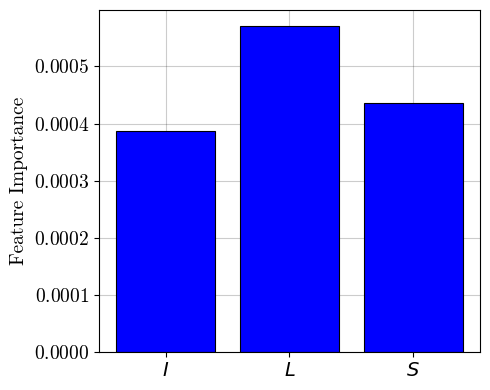

In [18]:
%%time
model = sm
X = X_tr

feature_importance = PDFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X, 
    categorical_features=categorical_feature_idx,
    feature_names=feature_names,
)

## Feature interaction

### Overall interaction

Using `PDFeatureInteractionDisplay.overall_interaction` method. 
- Required parameters:
    - model: surrogate model.
    - X: input spaces as a reference to compute the interaction. 

- Config parameters:
    - categorical_features: list of categorical features index. this is crucial for the computation.
    - feature_names: name of the features for the axis. 
    - sorted: if True, sort the features based on the feature importance. 



CPU times: user 6min 2s, sys: 11min 43s, total: 17min 46s
Wall time: 2min 22s


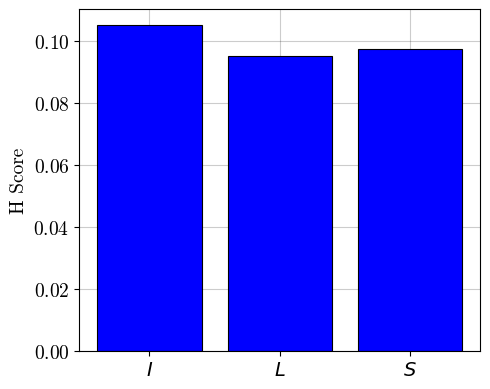

In [20]:
%%time
model = sm
X = X_tr

overall_pd_interaction = PDFeatureInteractionDisplay.overall_interaction(
    model,
    X,
    categorical_features=categorical_feature_idx, 
    feature_names=feature_names, 
)

### Pairwise interaction

Using `PDFeatureInteractionDisplay.pairwise_interaction` method. 
- Required parameters:
    - model: surrogate model.
    - X: input spaces as a reference to compute the interaction. 
    - feature_pairs: pair of features to compute the interaction

- Config parameters:
    - categorical_features: list of categorical features index. this is crucial for the computation.
    - feature_names: name of the features for the axis. 
    - sorted: if True, sort the features based on the feature importance. 

    

CPU times: user 5min 51s, sys: 11min 41s, total: 17min 33s
Wall time: 2min 19s


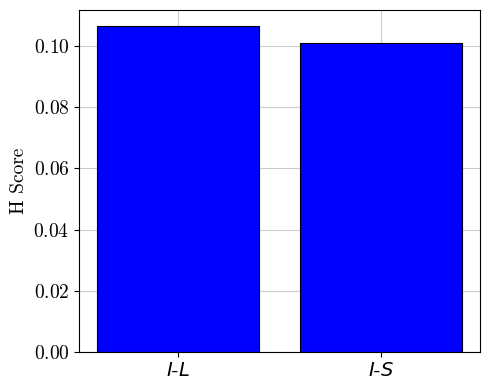

In [21]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]
feature_i = 0
feature_pairs = [
    (feature_i, feature_j) for feature_j in features if feature_j != feature_i
]

pairwise_pd_interaction = PDFeatureInteractionDisplay.pairwise_interaction(
    model,
    X,
    feature_pairs,
    categorical_features=categorical_feature_idx,
    feature_names=feature_names,
)

## 1 Dimension

Using `PartialDependenceDisplay.from_surrogate_model` method
- Required parameters:
    - model: surrogate model. 
    - X: input spaces as a reference to create the partial dependence plot. 
    - features: list of feature indexes to create the partial dependence plot on, i.e., y vs x_{i}.

- Config parameters:
    - kind: "average" for creating average dependence plot, "individual" for creating individual plots, "both" for plotting average and individual.
    - centered: if True, the partial dependence plot starts from zero. 
    - grid_resolution: Resolution of the numeric feature values. 
    - categorical features: list of categorical features index. 
    - inverse_categories_map: dictionary to map the integer encoded values of categorical features to its actual values. 
    - feature_names: name of the features for the axis. 
    - percentiles: start and end percentile of each feature when creating the plot. 


CPU times: user 25.9 s, sys: 50.3 s, total: 1min 16s
Wall time: 10.3 s


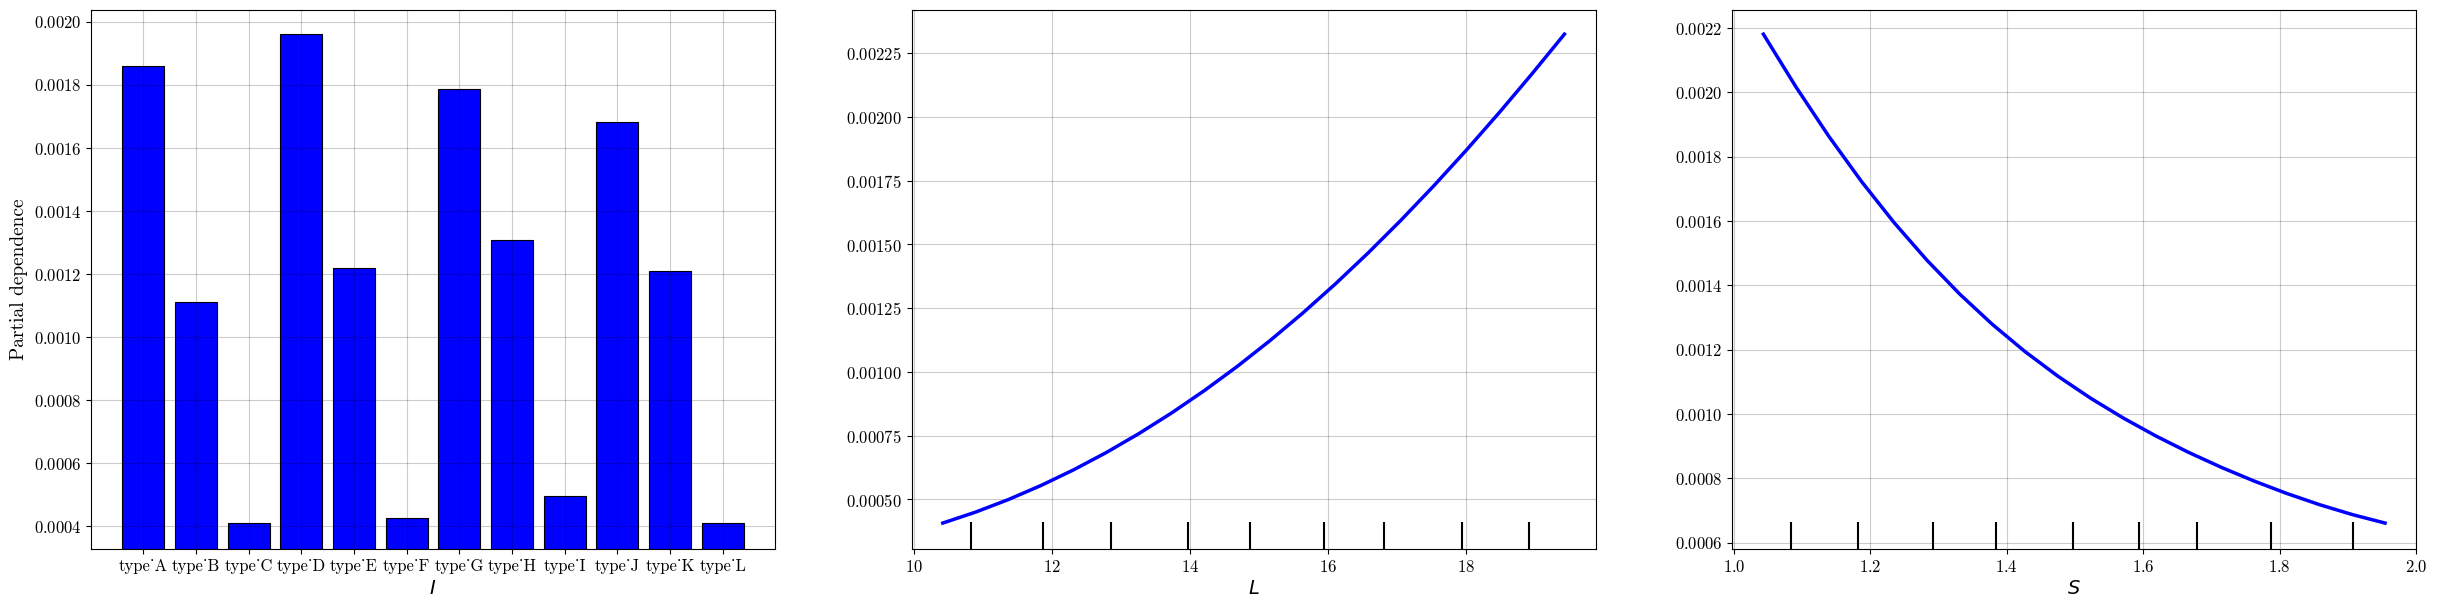

In [22]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_feature_idx, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='average',
    centered=False,
    figsize=[30, 7],
    inverse_categories_map=inverse_categories_map,
    )

CPU times: user 30.8 s, sys: 49.3 s, total: 1min 20s
Wall time: 11.1 s


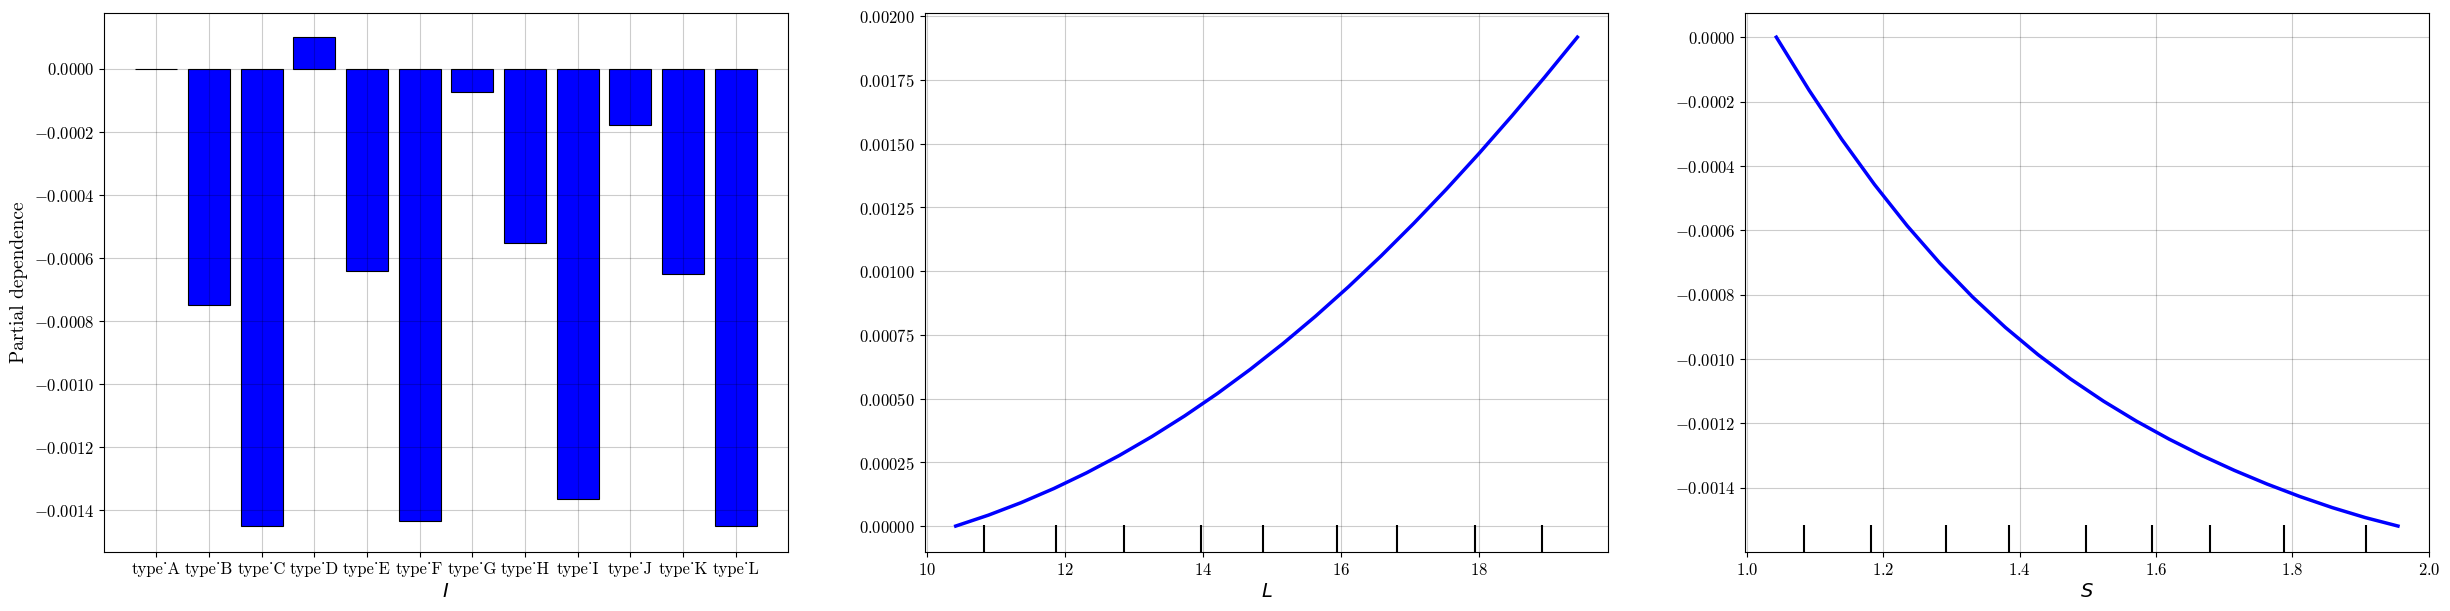

In [23]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]
categorical_features = categorical_feature_idx

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='average',
    centered=True,
    figsize=[30, 7],
    inverse_categories_map=inverse_categories_map,
    )

CPU times: user 28.6 s, sys: 49.4 s, total: 1min 17s
Wall time: 10.6 s


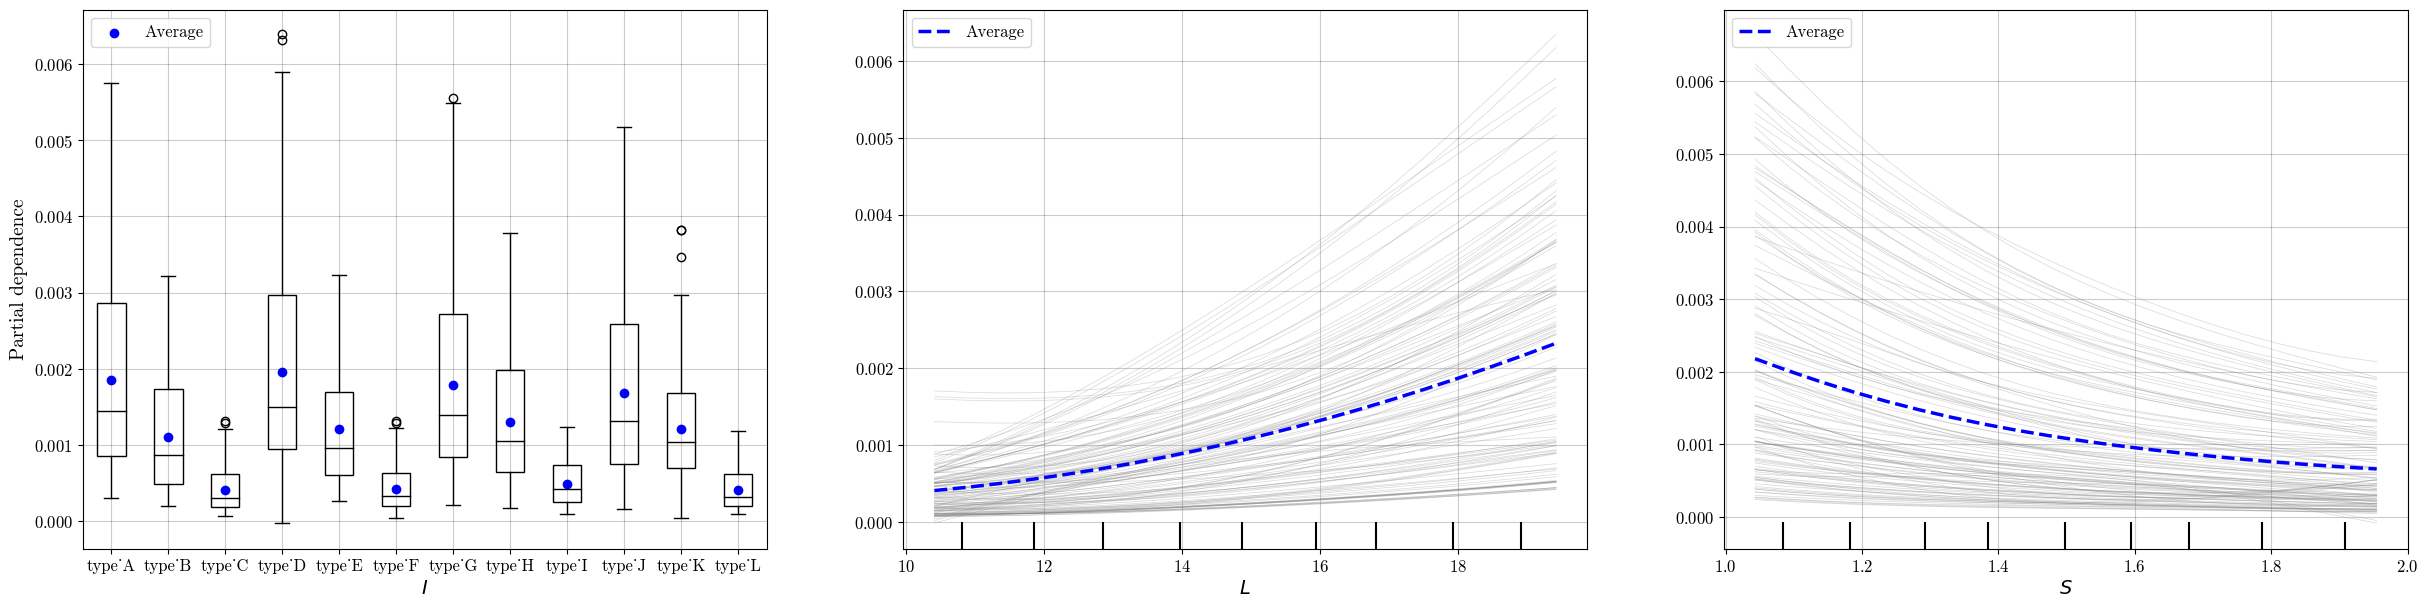

In [24]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]
categorical_features = categorical_feature_idx

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    centered=False,
    figsize=[30, 7],
    inverse_categories_map=inverse_categories_map,
    )

CPU times: user 35.2 s, sys: 44.3 s, total: 1min 19s
Wall time: 11.3 s


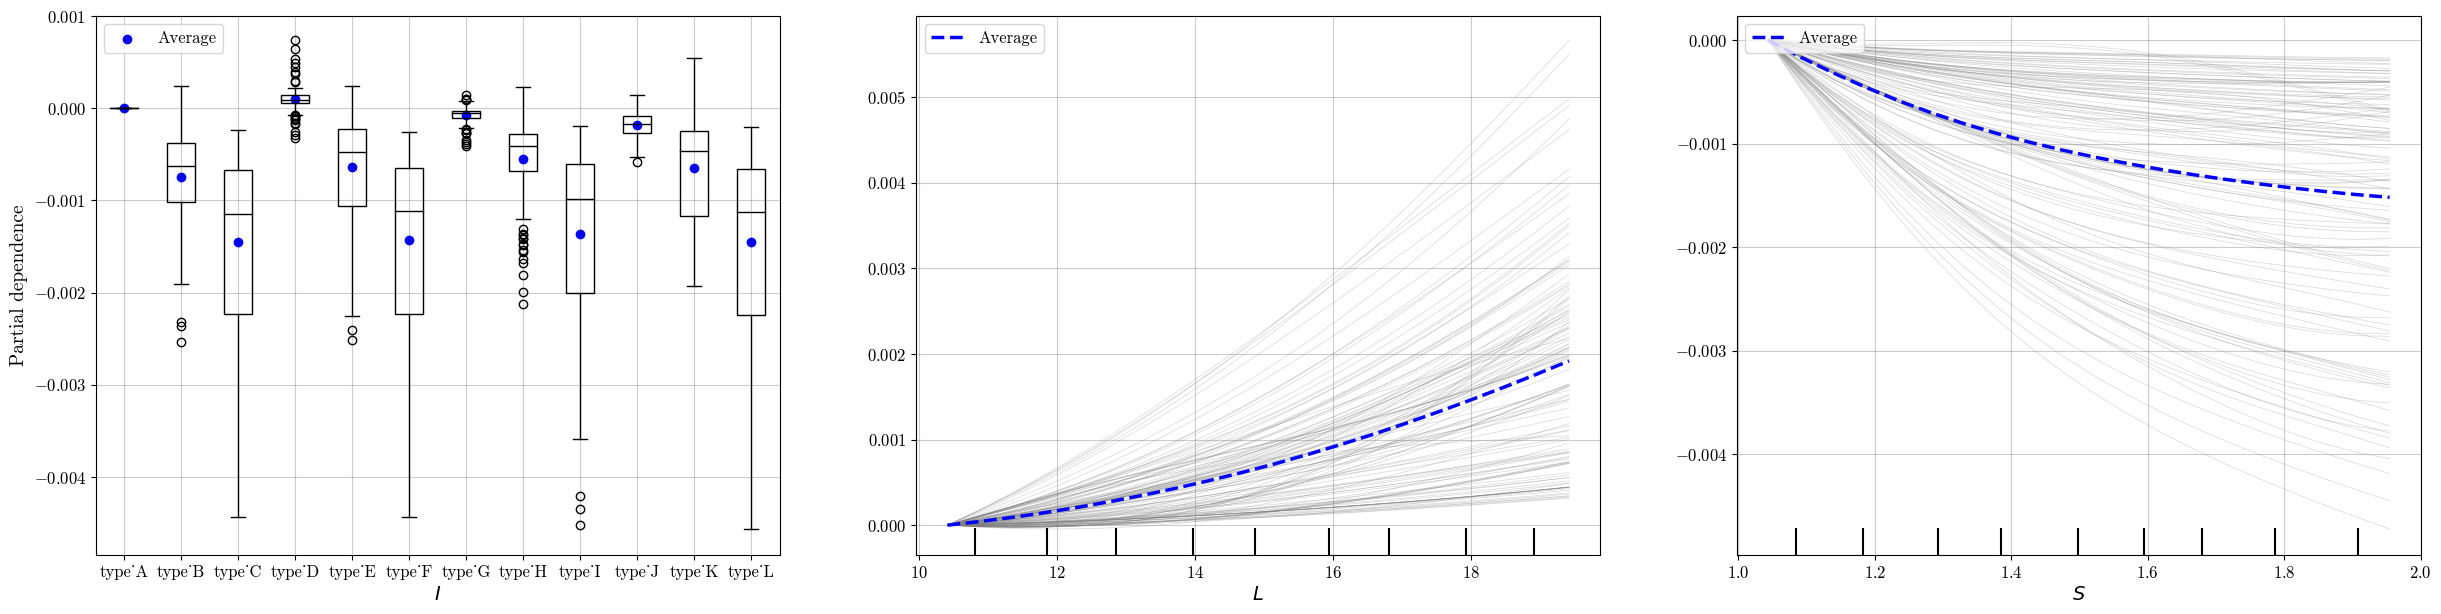

In [25]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]
categorical_features = categorical_feature_idx

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    centered=True,
    figsize=[30, 7],
    inverse_categories_map=inverse_categories_map,
    )

## 2 Dimension

Using `PartialDependenceDisplay.from_surrogate_model` method
- Required parameters:
    - model: surrogate model. 
    - X: input spaces as a reference to create the partial dependence plot. 
    - features: list of feature index pairs to create the partial dependence plot on, i.e., y vs (x_{i}, x_{j})

- Config parameters:
    - kind: "average" for creating average dependence plot, "individual" for creating individual plots, "both" for plotting average and individual.
    - centered: if True, the partial dependence plot starts from zero. 
    - grid_resolution: Resolution of the numeric feature values. 
    - categorical features: list of categorical features index. 
    - inverse_categories_map: dictionary to map the integer encoded values of categorical features to its actual values. 
    - feature_names: name of the features for the axis. 
    - percentiles: start and end percentile of each feature when creating the plot. 
    - annot_heatmap: if True, show the partial dependence value in the heatmap. 

CPU times: user 5min 26s, sys: 10min 13s, total: 15min 39s
Wall time: 2min 5s


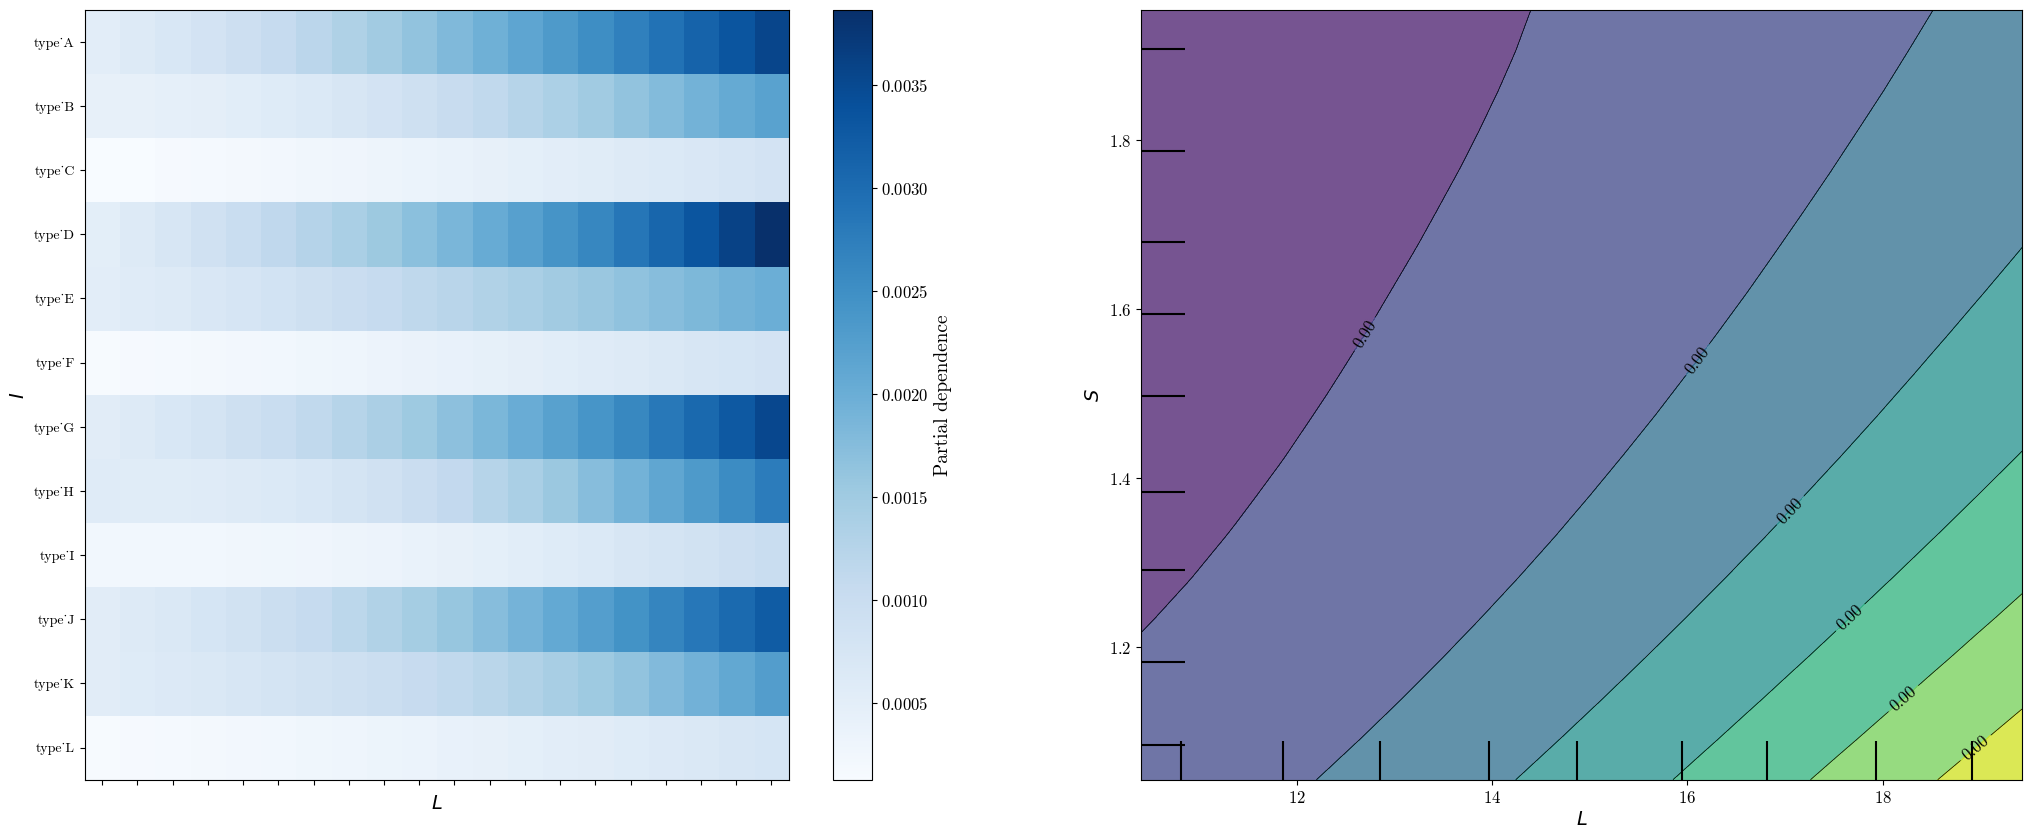

In [26]:
%%time
model = sm
X = X_tr
features = [(0, 1), (1, 2,)]
categorical_features = categorical_feature_idx

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    centered=False,
    figsize=[25, 10],
    inverse_categories_map=inverse_categories_map,
    )

CPU times: user 5min 24s, sys: 10min 23s, total: 15min 48s
Wall time: 2min 6s


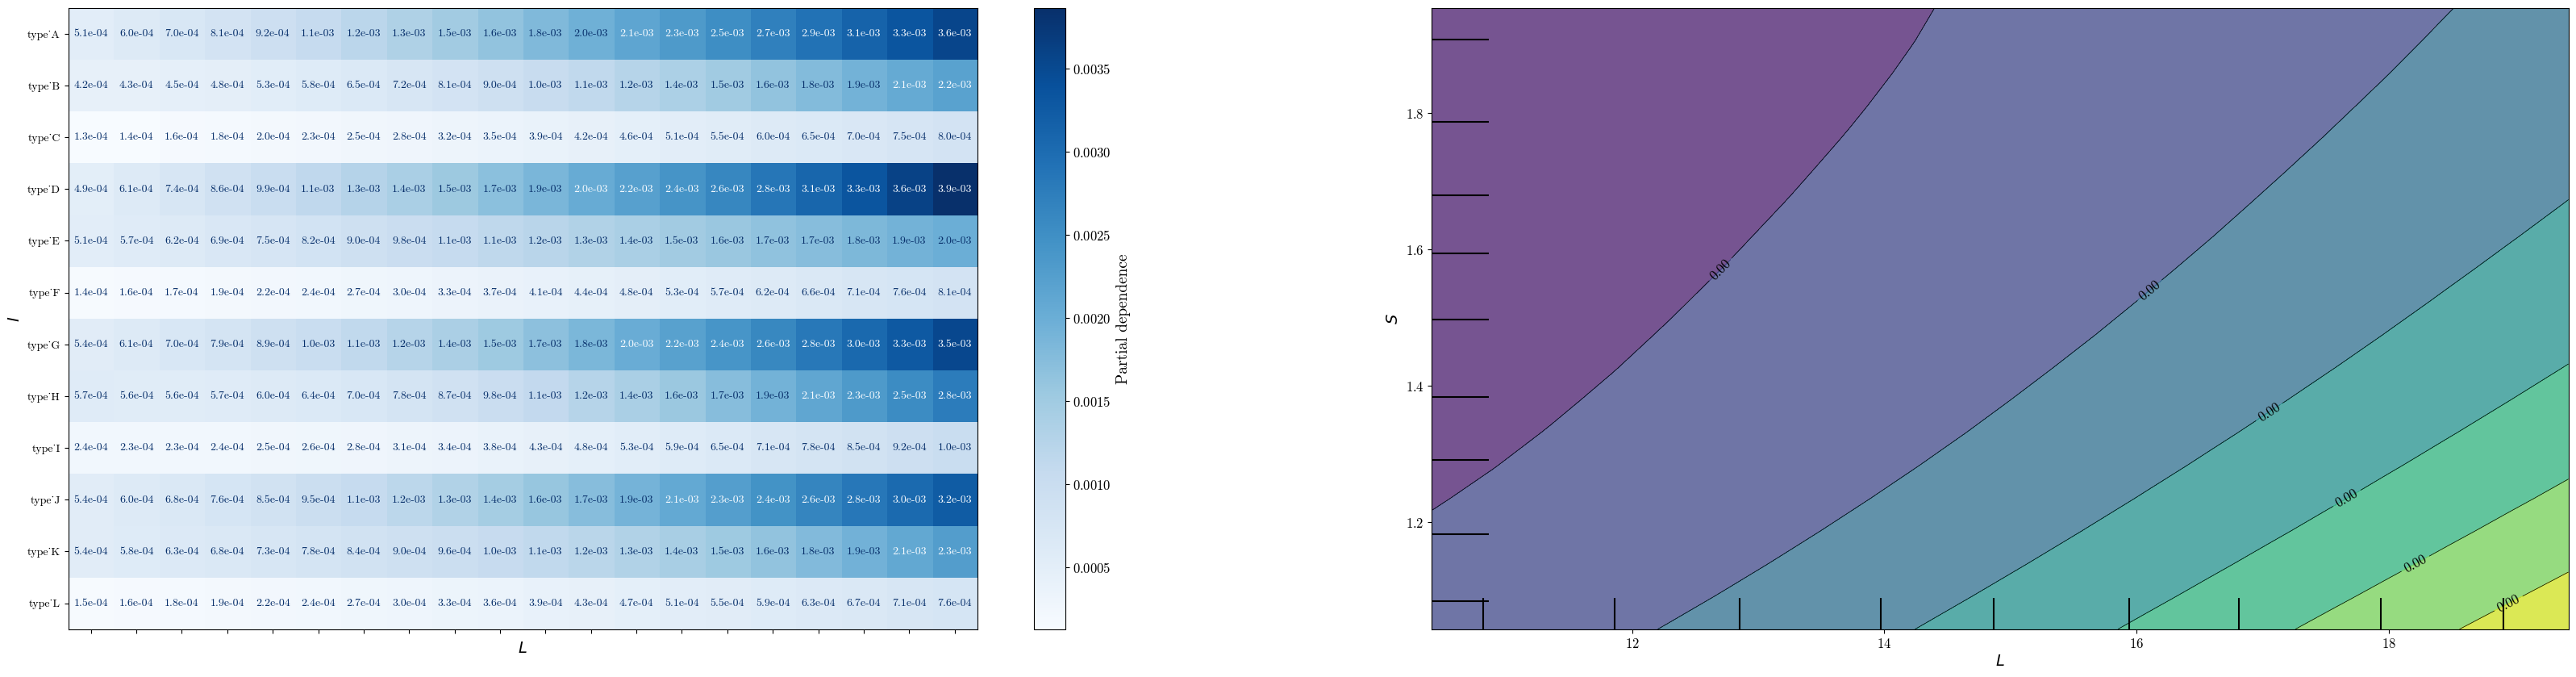

In [27]:
%%time
model = sm
X = X_tr
features = [(0, 1), (1, 2,)]
categorical_features = categorical_feature_idx

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    centered=False,
    figsize=[40, 10],
    inverse_categories_map=inverse_categories_map,
    annot_heatmap=True,
    )